In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd

# 0. Проверка тестов

В симуляции ниже нулевая гипотеза верна

In [7]:
a1, a2 = 1, 1
sigma1, sigma2 = 1, 2
n = 1000
alpha = 0.05
M = 10000
res = []
for _ in range(M):
    a = np.random.normal(loc=a1, scale=sigma1, size=n)
    b = np.random.normal(loc=a2, scale=sigma2, size=n)
    _, p_t = ttest_ind(a, b, equal_var=False, alternative='two-sided')
    _, p_mwu = mannwhitneyu(a, b, alternative='two-sided')
    res.append({'p_t': p_t, 'p_mwu': p_mwu})
df = pd.DataFrame(res)

array([[<AxesSubplot:title={'center':'p_t'}>,
        <AxesSubplot:title={'center':'p_mwu'}>]], dtype=object)

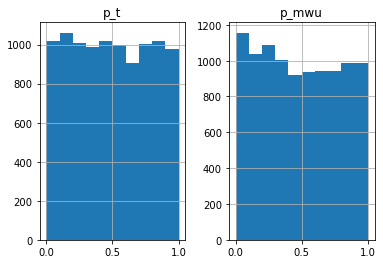

In [23]:
# Гистограммы p-value для T-теста и теста Манна-Уитни
df.hist()

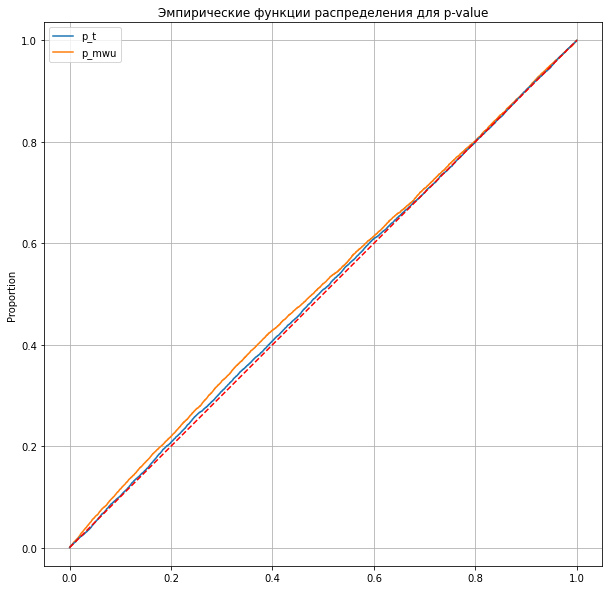

In [21]:
plt.figure(figsize=(10, 10))
sns.ecdfplot(data=df)
plt.title('Эмпирические функции распределения для p-value')
plt.grid(True)
plt.plot([0, 1], [0, 1], 'r--')
plt.axis('equal')
plt.show()

# Сравнение тестов

Тесты можно сравнивать, т.к. они в условиях задачи (для выборок из нормальных распределений и при сравнении средних) оба применимы. Для Т-тесты выборки дожны быть независимы и из нормальных распределений, это выполнено, в условии задачи не сказано, что $\sigma_1=\sigma_2$, поэтому ниже используется Welch T-test для выборок с разными дисперсиями. Для Манна-Уитни, вроде бы, требуется только независимость.

$H_0:a_1-a_2=0$, $H_1:a_1 - a_2 \ne 0$.

В симуляциях ниже гипотеза $H_0$ неверна, ошибка 2 рода - принятие $H_0$.

In [90]:
a1, a2 = 1, 1.2
sigma1, sigma2 = 1, 2
n = 1000
alpha = 0.05
M = 10000
res = []
for _ in range(M):
    a = np.random.normal(loc=a1, scale=sigma1, size=n)
    b = np.random.normal(loc=a2, scale=sigma2, size=n)
    _, p_t = ttest_ind(a, b, equal_var=False, alternative='two-sided')
    _, p_mwu = mannwhitneyu(a, b, alternative='two-sided')
    if p_t < alpha and p_mwu < alpha:
        e = 'Оба теста отвергнули H0'
    elif p_t < alpha and p_mwu >= alpha:
        e = 'T отвергнул H0, MWU - нет'
    elif p_t >= alpha and p_mwu < alpha:
        e = 'MWU отвергнул H0, T - нет'
    else:
        e = 'Оба теста не отвергнули H0'
    res.append({'p_t': p_t, 'p_mwu': p_mwu, 'e': e})
df = pd.DataFrame(res)

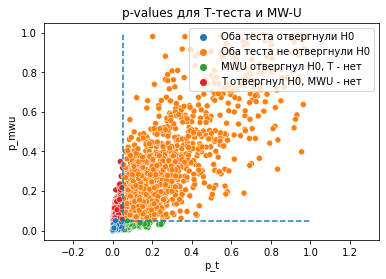

In [91]:
sns.scatterplot(data=df, x='p_t', y='p_mwu', hue='e')
plt.vlines(alpha, 0, 1, linestyles ='dashed')
plt.hlines(alpha, 0, 1, linestyles ='dashed')
plt.axis('equal')
plt.legend(loc='upper right')
plt.title('p-values для Т-теста и MW-U')
plt.show()

Получилось не очень информативно. В маленьком левом нижнем углу на самом деле больше точек, чем в большом правом верхнем, так что всё нормально.

In [94]:
# Частоты результатов тестов
df['e'].value_counts()/M

Оба теста отвергнули H0       0.7485
Оба теста не отвергнули H0    0.1679
T отвергнул H0, MWU - нет     0.0553
MWU отвергнул H0, T - нет     0.0283
Name: e, dtype: float64

Т.о. для MWU частота ошибки 2 рода = 0.0553+0.1679 = 0.2232, для T-теста 0.0283+0.1679 = 0.1962.
Соотв. мощности 0.7768 и 0.8038 (T-тест более мощный)

# Сравнение мощностей

In [117]:
res2 = []
alphas = np.linspace(0, 0.5, 100)
for alpha in alphas:
    power_t = 1 - sum(df['p_t'] > alpha) / M
    power_mwu = 1 - sum(df['p_mwu'] > alpha) / M
    res2.append({'alpha': alpha, 'power_t': power_t, 'power_mwu': power_mwu})
df2 = pd.DataFrame(res2)

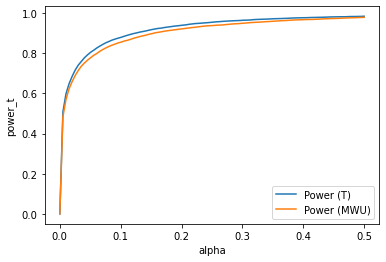

In [152]:
sns.lineplot(data=df2, x='alpha', y='power_t', label='Power (T)')
sns.lineplot(data=df2, x='alpha', y='power_mwu', label='Power (MWU)')
plt.legend()
plt.show()

Мощность Т-теста выше.

# Сравнение при наличии выбросов

In [142]:
# Добавим в каждую выборку d выбросов из нормального распределения с тем же средним и сигма=10, которые будут отклоняться больше 3 сигм от центра
d = 1000
res3 = []
for _ in range(M):
    a0 = np.random.normal(loc=a1, scale=sigma1, size=n - d)
    b0 = np.random.normal(loc=a2, scale=sigma2, size=n - d)
    outliers = np.random.normal(scale=10, size=10000)
    a_outliers = a1 + outliers[np.abs(outliers) > 3*sigma1]
    b_outliers = a2 + outliers[np.abs(outliers) > 3*sigma2]
    a = np.concatenate((a0, a_outliers[:d]))
    b = np.concatenate((b0, b_outliers[:d]))

    _, p_t = ttest_ind(a, b, equal_var=False, alternative='two-sided')
    _, p_mwu = mannwhitneyu(a, b, alternative='two-sided')
    
    res3.append({'p_t': p_t, 'p_mwu': p_mwu})
df3 = pd.DataFrame(res3)

In [150]:
res4 = []
alphas = np.linspace(0, 0.5, 100)
for alpha in alphas:
    error2_t = sum(df3['p_t'] > alpha) / M
    error2_mwu = sum(df3['p_mwu'] > alpha) / M
    res4.append({'alpha': alpha, 'error2_t': error2_t, 'error2_mwu': error2_mwu})
df4 = pd.DataFrame(res4)

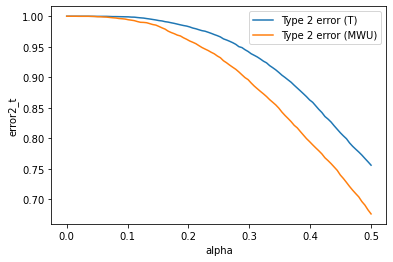

In [151]:
sns.lineplot(data=df4, x='alpha', y='error2_t', label='Type 2 error (T)')
sns.lineplot(data=df4, x='alpha', y='error2_mwu', label='Type 2 error (MWU)')
plt.legend()
plt.show()

При наличии выбросов вероятность ошибки 2 рода для MWU ниже, чем для Т-теста.